In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv


In [9]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Dense, Flatten
from zipfile import ZipFile
import cv2
from tqdm import tqdm 
from random import shuffle  

In [13]:
local_zip = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
zip_ref = ZipFile(local_zip, 'r')
zip_ref.extractall('training_all')
zip_ref.close()

In [14]:
local_zip = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'
zip_ref = ZipFile(local_zip, 'r')
zip_ref.extractall('test_all')
zip_ref.close()

In [15]:
print(len(os.listdir('/kaggle/working/test_all/test')))

12500


In [16]:
TRAIN_DIR = '/kaggle/working/training_all/train'
TEST_DIR = '/kaggle/working/test_all/test'
IMG_SIZE=100

In [40]:
type(os.listdir(TRAIN_DIR))

list

In [41]:
def label_img(img):
    label = img.split('.')[0]
    return label
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)[:2500]):
        label=label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),str(label)]) 
        
    shuffle(training_data)
    return training_data

In [42]:
train_data=np.array(create_train_data())
train_data_short=train_data
print(train_data.shape)
X= np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y= np.array([i[1] for i in train_data])

100%|██████████| 2500/2500 [00:05<00:00, 421.25it/s]


(2500, 2)


In [19]:
def create_test_data():
    test = []
    for img in tqdm(os.listdir(TEST_DIR)):
        label=label_img(img)
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        test.append([np.array(img)])
    shuffle(test)
    return test

In [20]:
test_data=np.array(create_test_data())
print(test_data.shape)
test= np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)

100%|██████████| 12500/12500 [00:29<00:00, 424.26it/s]


(12500, 1, 100, 100, 3)


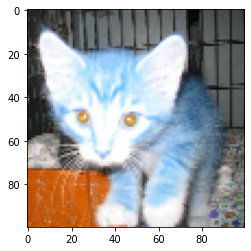

In [21]:
#show a pic
plt.imshow(X[4])

In [43]:
#ENCODE THE LABEL
lab=LabelEncoder()
Y=lab.fit_transform(Y)
Y=to_categorical(Y)

In [44]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.1)

In [45]:
#building model1: 8 layers of Conv2D, 4 layers of max pooling. filter size 32-64-96-96. One dense 256 nodes and outer layer.
model1 = Sequential()
model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (100,100,3)))
model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model1.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model1.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model1.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model1.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dense(2, activation = "sigmoid"))

model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [47]:
#Data Augmentation
datagen = ImageDataGenerator(rescale=1. / 255,zoom_range=0.1,rotation_range=10,horizontal_flip=True)
datagen.fit(x_train)

In [28]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 100, 100, 32)      2432      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 96)       

In [48]:
History = model1.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
#total fitting cost 40 mins

Epoch 1/20
18/18 [==============================] - 120s 7s/step - loss: 0.6917 - accuracy: 0.5183 - val_loss: 4.4110 - val_accuracy: 0.5360
Epoch 2/20


/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


18/18 [==============================] - 125s 7s/step - loss: 0.6917 - accuracy: 0.5181 - val_loss: 19.0383 - val_accuracy: 0.5460
Epoch 3/20
18/18 [==============================] - 120s 7s/step - loss: 0.6905 - accuracy: 0.5664 - val_loss: 61.6405 - val_accuracy: 0.5460
Epoch 4/20
18/18 [==============================] - 117s 6s/step - loss: 0.6786 - accuracy: 0.5683 - val_loss: 23.2419 - val_accuracy: 0.5920
Epoch 5/20
18/18 [==============================] - 119s 7s/step - loss: 0.6695 - accuracy: 0.5981 - val_loss: 42.5151 - val_accuracy: 0.6000
Epoch 6/20
18/18 [==============================] - 119s 7s/step - loss: 0.6558 - accuracy: 0.6209 - val_loss: 16.0862 - val_accuracy: 0.6440
Epoch 7/20
18/18 [==============================] - 122s 7s/step - loss: 0.6446 - accuracy: 0.6350 - val_loss: 70.1492 - val_accuracy: 0.6520
Epoch 8/20
18/18 [==============================] - 119s 7s/step - loss: 0.6268 - accuracy: 0.6546 - val_loss: 58.3551 - val_accuracy: 0.6700
Epoch 9/20
18/18 

In [49]:
pred1=model1.predict(test)

In [52]:
#write it to csv
imageid=[]
pred_prob=[]
for i in range(len(test)):
    imageid.append(i+1)
    pred_prob.append(pred1[i,1])
   
d={'id':imageid,'label':pred_prob}
ans=pd.DataFrame(d)
ans.to_csv('predictions1.csv',index=False)

In [53]:
#building model2: 4 layers of Conv2D, 4 layers of max pooling. filter size 32-64-96-96. One dense 256 nodes and outer layer.
model2 = Sequential()
model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (100,100,3)))
#model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model2.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model1.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model2.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model1.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dense(2, activation = "sigmoid"))

model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [54]:
from datetime import datetime
start=datetime.now()
History = model2.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
end=datetime.now()
time2=end-start
print('Time2=', time2)
#total fitting cost 10 mins

Epoch 1/20
18/18 [==============================] - 31s 2s/step - loss: 0.7079 - accuracy: 0.5094 - val_loss: 28.4143 - val_accuracy: 0.5360
Epoch 2/20
18/18 [==============================] - 31s 2s/step - loss: 0.6907 - accuracy: 0.5146 - val_loss: 26.8383 - val_accuracy: 0.5360
Epoch 3/20
18/18 [==============================] - 31s 2s/step - loss: 0.6889 - accuracy: 0.5096 - val_loss: 51.1820 - val_accuracy: 0.5400
Epoch 4/20
18/18 [==============================] - 31s 2s/step - loss: 0.6743 - accuracy: 0.5798 - val_loss: 128.9019 - val_accuracy: 0.5420
Epoch 5/20
18/18 [==============================] - 31s 2s/step - loss: 0.6610 - accuracy: 0.6082 - val_loss: 56.0131 - val_accuracy: 0.6120
Epoch 6/20
18/18 [==============================] - 31s 2s/step - loss: 0.6212 - accuracy: 0.6622 - val_loss: 55.4781 - val_accuracy: 0.6660
Epoch 7/20
18/18 [==============================] - 32s 2s/step - loss: 0.6279 - accuracy: 0.6641 - val_loss: 78.4640 - val_accuracy: 0.6080
Epoch 8/20
1

In [55]:
pred2=model2.predict(test)
#write it to csv
imageid=[]
pred_prob=[]
for i in range(len(test)):
    imageid.append(i+1)
    pred_prob.append(pred2[i,1])
   
d={'id':imageid,'label':pred_prob}
ans=pd.DataFrame(d)
ans.to_csv('predictions2.csv',index=False)

In [ ]:
#score is poor. I think overfitting is possibly due to too many epochs. Going to reduce to half (10)

In [57]:
#repeat model 1 but with 10 epoch.
#building model3: 8 layers of Conv2D, 4 layers of max pooling. filter size 32-64-96-96. One dense 256 nodes and outer layer.
model3 = Sequential()
model3.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (100,100,3)))
model3.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model3.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model3.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model3.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model3.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model3.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model3.add(Flatten())
model3.add(Dense(256, activation = "relu"))
model3.add(Dense(2, activation = "sigmoid"))

model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

from datetime import datetime
start=datetime.now()
History = model3.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 10, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
end=datetime.now()
time3=end-start
print('Time3=', time3) #20 min

Epoch 1/10
18/18 [==============================] - 119s 7s/step - loss: 0.6963 - accuracy: 0.4967 - val_loss: 0.8000 - val_accuracy: 0.5360
Epoch 2/10
18/18 [==============================] - 118s 7s/step - loss: 0.6927 - accuracy: 0.5103 - val_loss: 22.5508 - val_accuracy: 0.5360
Epoch 3/10
18/18 [==============================] - 119s 7s/step - loss: 0.6930 - accuracy: 0.4960 - val_loss: 0.7408 - val_accuracy: 0.4660
Epoch 4/10
18/18 [==============================] - 129s 7s/step - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.7296 - val_accuracy: 0.4640
Epoch 5/10
18/18 [==============================] - 118s 7s/step - loss: 0.6931 - accuracy: 0.5061 - val_loss: 0.7146 - val_accuracy: 0.4640
Epoch 6/10
18/18 [==============================] - 121s 7s/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.7186 - val_accuracy: 0.4640
Epoch 7/10
18/18 [==============================] - 118s 7s/step - loss: 0.6930 - accuracy: 0.5150 - val_loss: 0.7050 - val_accuracy: 0.4600
Epoch 8/10
1

In [58]:
pred3=model3.predict(test)
#write it to csv
imageid=[]
pred_prob=[]
for i in range(len(test)):
    imageid.append(i+1)
    pred_prob.append(pred3[i,1])
   
d={'id':imageid,'label':pred_prob}
ans=pd.DataFrame(d)
ans.to_csv('predictions3.csv',index=False)

In [59]:
#building model4: 10epoch 4 layers of Conv2D, 4 layers of max pooling. filter size 32-64-96-96. One dense 256 nodes and outer layer.
model4 = Sequential()
model4.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (100,100,3)))
#model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model4.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model1.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model4.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model1.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model4.add(Flatten())
model4.add(Dense(256, activation = "relu"))
model4.add(Dense(2, activation = "sigmoid"))

model4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
from datetime import datetime
start=datetime.now()
History = model4.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 10, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
end=datetime.now()
time4=end-start
print('Time4=', time4) # min

Epoch 1/10
18/18 [==============================] - 31s 2s/step - loss: 0.6990 - accuracy: 0.5075 - val_loss: 8.4315 - val_accuracy: 0.5380
Epoch 2/10
18/18 [==============================] - 31s 2s/step - loss: 0.6884 - accuracy: 0.5425 - val_loss: 15.5135 - val_accuracy: 0.5460
Epoch 3/10
18/18 [==============================] - 31s 2s/step - loss: 0.6800 - accuracy: 0.5627 - val_loss: 17.7605 - val_accuracy: 0.5920
Epoch 4/10
18/18 [==============================] - 31s 2s/step - loss: 0.6538 - accuracy: 0.6090 - val_loss: 94.3178 - val_accuracy: 0.5540
Epoch 5/10
18/18 [==============================] - 31s 2s/step - loss: 0.6419 - accuracy: 0.6406 - val_loss: 87.9238 - val_accuracy: 0.6140
Epoch 6/10
18/18 [==============================] - 31s 2s/step - loss: 0.6323 - accuracy: 0.6465 - val_loss: 39.6624 - val_accuracy: 0.6280
Epoch 7/10
18/18 [==============================] - 46s 3s/step - loss: 0.5984 - accuracy: 0.6869 - val_loss: 125.7480 - val_accuracy: 0.5640
Epoch 8/10
18

In [ ]:
pred4=model4.predict(test)
#write it to csv
imageid=[]
pred_prob=[]
for i in range(len(test)):
    imageid.append(i+1)
    pred_prob.append(pred4[i,1])
   
d={'id':imageid,'label':pred_prob}
ans=pd.DataFrame(d)
ans.to_csv('predictions4.csv',index=False)